# **CS 418 Final Project: Data-Driven Course Insights: Predicting Grade Trends 💯**<br>
**Github Repository Link:**<br>

This project is to predict course grade distributions and popularity rankings for upcoming semesters, enabling students to make informed decisions about their class selections. By shifting the focus from individual grade predictions to overall course outcomes, the project provides insights into course grading trends and demand. It uses clustering to rank courses based on student performance and popularity, and topic-based grouping to help students discover courses aligned with their interests, factoring in professor expertise and class attributes. This data-driven tool uncovers hidden patterns, aiding both students and academic planning. <br>

**Authors:**
| **Name**  | **Email** | **Github Handle** | **Contributions** | 
|---|---|---|---|
| Arlette Diaz | adiaz218@uic.edu | adiaz218 |[INSERT TEXT HERE..]|
| Marianne Hernandez | mhern85@uic.edu | marhern19 |[INSERT TEXT HERE..]|
| Nandini Jirobe | njiro2@uic.edu | nandinijirobe ||
| Sharadruthi Muppidi | smuppi2@uic.edu | sharadruthi-uic |[INSERT TEXT HERE..]|
| Sonina Mut | smut3@uic.edu | snina22 |[INSERT TEXT HERE..]|
| Yuting Lu | lyuti@uic.edu | yutinglu103 |[INSERT TEXT HERE..]|

**Arlette Diaz:** 
* Cleaned the grade distribution data set for Comupter Science classes
* Cleaned the grade distribution data set for MEIE classes
* Cleaned the lecutre data set for all classes (CS, IE, ME)

<br>**Marianne Hernandez:** 
* Scraped the data for Computer Science course offerings between Spring 2014 - Summer 2024
* Scraped the data for Mechanical Engineering course offerings between Spring 2014 - Summer 2024
* Scraped the data for Industrial Engineering course offerings between Spring 2014 - Summer 2024
* Converted data into .csv files for group to use after cleaning up and reorganizing relevant information
* Worked on EDA section

<br>**Nandini Jirobe:** 
* Collected Rate My Professor ratings for professors who taught Mechanical and Industrial Enginnering classes from 2014-2024
* Collected Rate My Professor ratings for professors in the Computer Science classes from 2014-2024
* Collected Google Scholar research interests of professors who taught Mechanical and Industrial Enginnering classes from 2014-2024
* Collected Google Scholar research interests of professors in the Computer Science classes from 2014-2024
* Collected course description data for computer science courses taught at UIC. 
* Created Data Visualization # 1 

<br>**Sharadruthi Muppidi:** 
* Worked on ML Model Training and Analysis (Part 5),  Worked on Visualizations ( Part 4: 1-4) 

<br>**Sonina Mut:** 
* Collected UIC Grade Distribution for professors who taught Mechanical and Industrial Enginnering classes from 2014-2024
* Collected UIC Grade Distribution for professors in the Computer Science classes from 2014-2024
* Collected Rate My Professor ratings for professors who taught Mechanical and Industrial Enginnering classes from 2014-2024
* Collected Rate My Professor ratings for professors in the Computer Science classes from 2014-2024
* Completed Data Clean, Dataset 2.1 for Rate My professor from 2014-2024
* Completed Data Clean, Dataset 2.2 for Rate My professor from 2014-2024

<br>**Yuting Lu:** 
* Came up with some data visualization ideas.
* Completed data visualizations 5

### **Part 1: Install & Import Libraries 📦**

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import warnings

warnings.filterwarnings('ignore')
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import make_interp_spline

### **Part 2: Load Datasets 🔄**

In [17]:
cs_grades = pd.read_csv('uic_GD_CS_14_24.csv') # CS courses Grade distribution data 
meie_grades = pd.read_csv('uic_GD_MEIE_14_24.csv') # ME/IE courses Grade distribution data 
cs_rmp = pd.read_csv('uic_RMP_CS_14_24.csv') # CS Rate My Professor Data
meie_rmp = pd.read_csv('CS418_Team5_DataSet - RMP_MEIE_14_24.csv') # ME/IE Rate My Professor Data
cs_gs = pd.read_csv('CS418_Team5_DataSet - GS_CS_14_24.csv') # CS Professor Google Scholar Data
meie_gs = pd.read_csv('CS418_Team5_DataSet - GS_MEIE_14_24.csv') # ME/IE Professor Google Scholar Data
cs_lectures = pd.read_csv('uic_CS_lectures_all_semesters.csv') # CS Lecture Data
me_lectures = pd.read_csv('uic_ME_lectures_all_semesters.csv') # ME Lecture Data
ie_lectures = pd.read_csv('uic_IE_lectures_all_semesters.csv') # IE Lecture Data
cs_descrip = pd.read_csv('CS418_Team5_DataSet - CS_Descrip.csv') # Course Description Data

### **Part 3: Data Cleaning 🧹**

In [ ]:
# ============== Dataset 1: Grade Distribution ============== #
grade_dist = pd.concat([cs_grades, meie_grades], ignore_index=True) # Append both CS and ME/IE dataframes
grade_dist = grade_dist.loc[:, (grade_dist != 0).any(axis=0)] # Drop columns where all values are zero
grade_dist = grade_dist[~grade_dist['CRS TITLE'].str.contains("research|seminar", case=False, na=False)] # Drop rows where CRS TITLE (course title) contains "research" or "seminar" (case-insensitive)
grade_dist.rename(columns={'Primary Instructor': 'Instructor'}, inplace=True) # Rename column
grade_dist.rename(columns={'CRS NBR': 'CRS NUM'}, inplace=True) # Rename column
grade_dist = grade_dist[grade_dist['CRS NUM'].between(100, 599)] # Filter for courses
grade_dist["CRS LVL"] = (grade_dist["CRS NUM"]//100)*100
grade_dist.drop(["DFR", "I", "NR", "S", "U", "DEPT CD"], axis=1, inplace=True) # drop unecessary columns

# Convert all numeric columns to integers or floats
for col in grade_dist.columns:
    grade_dist[col] = pd.to_numeric(grade_dist[col], errors='ignore')

grade_dist.head(5)

In [ ]:
# ============== Dataset 2: Rate My Professor ============== #
rate_my_prof = pd.concat([cs_rmp, meie_rmp], ignore_index=True) # Append both CS and ME/IE rmp dataframes

# Convert all numeric columns rate_my_prof to integers or floats
rate_my_prof["Rating"] = pd.to_numeric(rate_my_prof["Rating"], errors='coerce')
rate_my_prof["Num Reviews"] = pd.to_numeric(rate_my_prof["Num Reviews"], errors='coerce')

# Fill missing values with average values of that column
rate_my_prof['Rating'] = rate_my_prof['Rating'].fillna(rate_my_prof["Rating"].mean())
rate_my_prof['Num Reviews'] = rate_my_prof['Num Reviews'].fillna(rate_my_prof["Num Reviews"].mean()) 

# Merge the grade distribution and RMP datasets
grade_dist_rmp = pd.merge(grade_dist, rate_my_prof, on='Instructor', how='left') 

grade_dist_rmp.head(5)

In [42]:
# ============== Dataset 3: CLASS SCHEDULER DATA ============== #

# ============== Dataset 3: Helper Functions ============== #
def update_method_type(method_type: str) -> str:
    """
    Standardize method type names across different years
    """
    method_mapping = {
        'Online Synchronous': ['Meet online at set times'],
        'Online Asynchronous': ['Online with deadlines'],
        'On Campus': ['Meet on campus'],
        'Hybrid': ['On campus and online', 'Mixed in-person & online instr']
    }
    
    for standard_name, variants in method_mapping.items():
        if method_type == standard_name or method_type in variants:
            return standard_name
            
    return method_type

def process_lecture_data(cs_lectures: pd.DataFrame, me_lectures: pd.DataFrame, ie_lectures: pd.DataFrame) -> pd.DataFrame:
    """
    Process and combine lecture data from different departments
    """
    # Combine all dataframes
    all_lecture_data = pd.concat([cs_lectures, me_lectures, ie_lectures], ignore_index=True)
    
    # Convert year to numeric
    all_lecture_data["Year"] = pd.to_numeric(all_lecture_data["Year"], errors='coerce')
    
    # Split course code into subject and number
    all_lecture_data[['CRS SUBJ CD', 'CRS NUM']] = all_lecture_data['Course Code'].str.split(' ', expand=True)
    
    # Standardize method types
    all_lecture_data['Method'] = all_lecture_data['Method'].apply(update_method_type)
    
    final_columns = [
        'CRS SUBJ CD',
        'CRS NUM',
        'Days per Week',  # Changed from 'Days' to match actual column name
        'Instructor',
        'Method',
        'Semester',
        'Year',
        'Time of Day',
        'Duration of Class (minutes)'
    ]
    
    # Select only needed columns in specified order
    result = all_lecture_data[final_columns]
    result = result.rename(columns={'Days per Week': 'Days'}) # Rename the 'Days per Week' column to 'Days'
    return result

# ============== Dataset 3: Lecture Data Cleaning ============== #
processed_data = process_lecture_data(cs_lectures, me_lectures, ie_lectures)
processed_data.head(5)

,CRS SUBJ CD,CRS NUM,Days,Instructor,Method,Semester,Year,Time of Day,Duration of Class (minutes)
0,CS,100,3,"Reed, D",On Campus,Spring,2014,Afternoon,50
1,CS,107,2,"Theys, M",On Campus,Spring,2014,Afternoon,75
2,CS,109,2,"Hummel, J",On Campus,Spring,2014,Afternoon,50
3,CS,111,2,"Troy, P",On Campus,Spring,2014,Afternoon,75
4,CS,141,3,"Reed, D",On Campus,Spring,2014,Afternoon,50


### **Part 4: Data Visualizations 📊**<br>
#### **Data Visualization #1: Average Grade of Course Level in Computer Science** <br>
**Hypothesis:** [TODO: ill do this later --nandini] <br>
**Conclusion:** [TODO: ill do this later --nandini]

Text(0.5, 1.0, 'Avg Grade of Each Course Level in Computer Science')

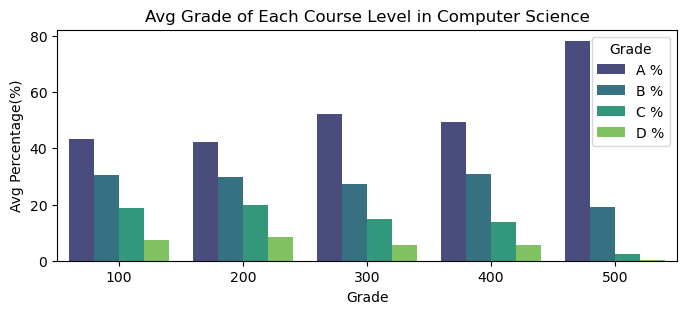

In [21]:
# save a copy of just the cs clases into gd_copy
gd_copy = grade_dist[grade_dist["CRS SUBJ CD"] == "CS"]

# Calculate the grade distribution as a percentage of the total registered students
for grade in ['A', 'B', 'C', 'D', 'F']:
    gd_copy[f'{grade} %'] = (gd_copy[grade] / gd_copy['Grade Regs']) * 100

# calculate percentages of A, B, C, D grades in each course level
gd_copy = gd_copy.groupby("CRS LVL")[["A %", "B %", "C %", "D %"]].mean().reset_index()
gd_copy["sum"] = gd_copy['A %'] + gd_copy['B %'] + gd_copy['C %'] + gd_copy['D %']
gd_copy["A %"] = (gd_copy["A %"]/gd_copy["sum"])*100
gd_copy["B %"] = (gd_copy["B %"]/gd_copy["sum"])*100
gd_copy["C %"] = (gd_copy["C %"]/gd_copy["sum"])*100
gd_copy["D %"] = (gd_copy["D %"]/gd_copy["sum"])*100

# this rotates the dataframe so it is into long format instead of wide format
gd_copy= gd_copy.melt(id_vars=["CRS LVL"], value_vars=["A %", "B %", "C %", "D %"], var_name="Grade", value_name="Avg percent")

# Use seaborn barplot to plot the figure above. Customize with color palette='viridis'
plt.figure(figsize=(8,3))
avgCSgrades_bar_chart = sns.barplot(data=gd_copy, x = 'CRS LVL', y = 'Avg percent', hue='Grade', palette='viridis')
avgCSgrades_bar_chart.set_xlabel("Grade")
avgCSgrades_bar_chart.set_ylabel("Avg Percentage(%)")
avgCSgrades_bar_chart.set_title("Avg Grade of Each Course Level in Computer Science")

**Conclusion:**
 
Higher level computer science courses, particularly courses at the 500 level, have a higher percentage of students receiving "A" grade indicates than lower level courses, according to the visualization. This implies that advanced courses are typically taken by students who are more motivated or prepared, such as graduate students, or that advanced course grading specifications are flexible. However, the comparatively greater rates of C's and D's in 100 and 200 level courses might be an indication of the difficulties beginning students have adjusting to college level coursework. Administrators and instructors can use these data to determine places where lower level courses might benefit from extra assistance to enhance student performance.

#### **Data Visualization #2: Online Course Percentage by Year for Different Departments**

**Hypothesis:** After the pandemic, computer science courses are still able to be offered online compared to more hands-on majors such as Industrial or Mechanical Engineering.

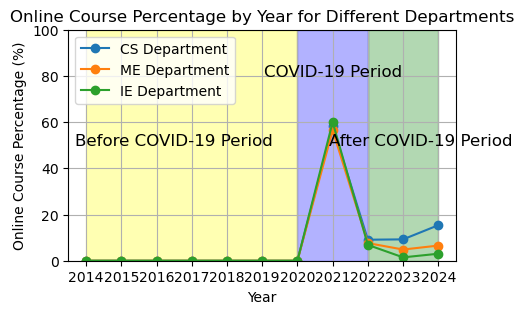

In [22]:
cs_data = cs_lectures # get data in CS department
cs_data['Is_Online'] = cs_data['Method'].str.contains('Online', case=False, na=False) # mark online course
cs_online_ratio_by_year = cs_data.groupby('Year')['Is_Online'].mean() * 100 # calculate the ratio of online course for each year
cs_online_ratio_df = cs_online_ratio_by_year.reset_index() # Create new table
cs_online_ratio_df.columns = ['Year', 'Online_Course_Percentage'] 

ie_data = ie_lectures # get data in IE department
ie_data['Is_Online'] = ie_data['Method'].str.contains('Online', case=False, na=False) # mark online course
ie_online_ratio_by_year = ie_data.groupby('Year')['Is_Online'].mean() * 100 # calculate the ratio of online course for each year
ie_online_ratio_df = ie_online_ratio_by_year.reset_index() # Create new table
ie_online_ratio_df.columns = ['Year', 'Online_Course_Percentage']

me_data = me_lectures # get data in ME department
me_data['Is_Online'] = me_data['Method'].str.contains('Online', case=False, na=False) # mark online course
me_online_ratio_by_year = me_data.groupby('Year')['Is_Online'].mean() * 100 # calculate the ratio of online course for each year
me_online_ratio_df = me_online_ratio_by_year.reset_index() # Create new table
me_online_ratio_df.columns = ['Year', 'Online_Course_Percentage']

plt.figure(figsize=(5, 3))
plt.plot(cs_online_ratio_df['Year'], cs_online_ratio_df['Online_Course_Percentage'], marker='o', linestyle='-', label='CS Department')
plt.plot(me_online_ratio_df['Year'], me_online_ratio_df['Online_Course_Percentage'], marker='o', linestyle='-', label='ME Department')
plt.plot(ie_online_ratio_df['Year'], ie_online_ratio_df['Online_Course_Percentage'], marker='o', linestyle='-', label='IE Department')

# add background
plt.axvspan(2014, 2020, color='yellow', alpha=0.3)
plt.text(2016.5, 50, 'Before COVID-19 Period', color='black', fontsize=12, ha='center')
plt.axvspan(2020, 2022, color='blue', alpha=0.3)
plt.text(2021, 80, 'COVID-19 Period', color='black', fontsize=12, ha='center')
plt.axvspan(2022, 2024, color='green', alpha=0.3)
plt.text(2023.5, 50, 'After COVID-19 Period', color='black', fontsize=12, ha='center')

plt.title('Online Course Percentage by Year for Different Departments')
plt.xlabel('Year')
plt.ylabel('Online Course Percentage (%)')
plt.xticks(range(2014, 2025))
plt.ylim(0, 100)
plt.legend()
plt.grid(True)
plt.show()

**Conclusion:** 
Changes in Online Course Proportion: 1. During COVID-19 Period, the proportion of online courses in all departments suddenly increased sharply, reaching nearly 100%. After COVID-19 Period, the proportion of online courses dropped significantly and stabilized. This indicates that after the pandemic, some courses returned to in-person instruction, although some habits of online teaching might have remained, especially in the CS department, which still had a relatively high proportion of online courses in 2023-2024 and most of the online courses are concentrated in the summer semester after COVID-19 for every department. 2.Differences Among Departments:After the the COVID-19 period, we can see that the CS department (blue line) retained more online courses, while the ME and IE departments largely returned to nearly 0% online courses. 

#### **Data Visualization #3: Rate My Professor and Student Retention**<br>
**Hypothesis:** Student registrations increase with higher instructor ratings, while withdrawal rates decrease as ratings improve. <br>


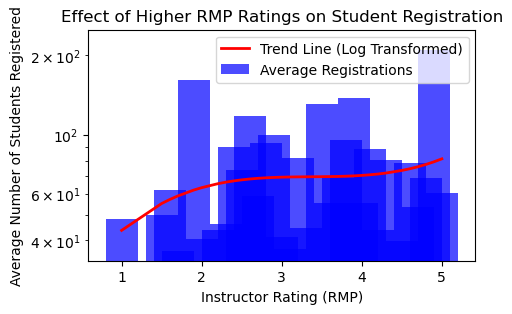

In [ ]:
cs_grades['Primary Instructor'] = cs_grades['Primary Instructor'].str.strip()
cs_rmp['Instructor'] = cs_rmp['Instructor'].str.strip()
merged_data = pd.merge(cs_grades, cs_rmp, left_on='Primary Instructor', right_on='Instructor', how='inner')

grouped_courses = merged_data.groupby([ 'YEAR','SEMESTER', 'CRS NBR','CRS TITLE'])
multiple_instructors = grouped_courses.filter(lambda x: len(x['Primary Instructor'].unique()) > 2)
grouped_registrations = merged_data.groupby('Rating')['Grade Regs'].mean().reset_index()
x = grouped_registrations['Rating']
y = grouped_registrations['Grade Regs']
y_log = np.log(y)
coefficients = np.polyfit(x, y_log, deg=3)
trend_line_log = np.polyval(coefficients, x)

trend_line = np.exp(trend_line_log)
plt.figure(figsize=(5, 3))
plt.bar(x, y, width=0.4, color='blue', alpha=0.7, label='Average Registrations')
plt.yscale('log')
plt.plot(x, trend_line, color='red', linestyle='-', linewidth=2, label='Trend Line (Log Transformed)')
plt.xlabel('Instructor Rating (RMP)')
plt.ylabel('Average Number of Students Registered')
plt.title('Effect of Higher RMP Ratings on Student Registration')
plt.ylim(0, 250)
plt.legend()
plt.show()

**Conclusion: Effect of Higher RMP Ratings on Student Registration:**
The visualization examines the relationship between instructors' ratings on Rate My Professors (RMP) and the average number of students registering for their courses. The blue bars represent the average number of students registered at each instructor rating level, while the red curve serves as a logarithmic trend line, highlighting the overall trend in the data. Student registration and instructor ratings are positively correlated, according to the figure. More students are typically drawn to teachers with higher RMP ratings. There are far fewer students registered at low ratings (about 1-2) than at ratings in the 4-5 range. As ratings rise, the trend line shows that the number of registrants increases exponentially, leveling off at higher rating levels. This indicates that students are more tempted to sign up for classes offered by instructors who are more well-known or who are thought to be more effective teachers, as indicated by their RMP scores.

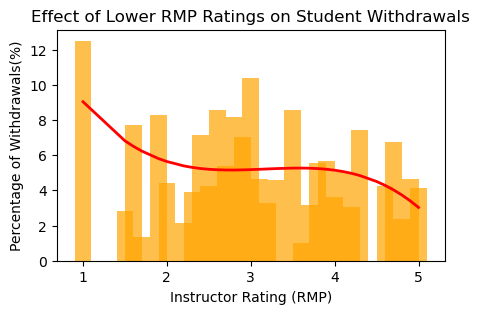

In [24]:
grouped_data = merged_data.groupby('Rating').agg({'W': 'sum', 'Grade Regs': 'sum'}).reset_index()
grouped_data['Withdraw_Rate'] = (grouped_data['W'] / grouped_data['Grade Regs'])*100
x = grouped_data['Rating']
y = grouped_data['Withdraw_Rate']
coefficients = np.polyfit(x, y, deg=3)
trend_line = np.polyval(coefficients, x)

plt.figure(figsize=(5, 3))
plt.bar(grouped_data['Rating'], grouped_data['Withdraw_Rate'], width=0.2, color='orange', alpha=0.7, label='Withdrawal Rate')
plt.plot(x, trend_line, color='red', linestyle='-', linewidth=2, label='Trend Line')
plt.xlabel('Instructor Rating (RMP)')
plt.ylabel('Percentage of Withdrawals(%)')
plt.title('Effect of Lower RMP Ratings on Student Withdrawals')
plt.show()

**Conclusion and Insights**

These visualizations demonstrate how instructor ratings have a big influence on student enrollment and retention. Higher RMP instructors successfully maintain their students in addition to drawing in new ones. On the other hand, lower rated instructors have trouble drawing in and keeping students, as seen by lower registrations and greater withdrawal rates.  These outcomes highlight the need of encouraging excellent teaching methods for educational institutions in order to raise student engagement and satisfaction. Enhancing teacher support through professional development programs can raise ratings, lower withdrawal rates, and ultimately improve the learning environment. It can also assist teachers in identifying and addressing areas for improvement by encouraging students to offer constructive criticism on their educational experiences. The importance of excellent instruction in fostering student achievement and engagement is shown by these outcomes.

### **Part 4: Machine Learning Analysis 🧠**

#### **Machine Learning #1: [INSERT TITLE]**<br>
**[TOPIC]:** TEXT..... <br>
**[TOPIC]:** TEXT..... <br>


#### **Machine Learning #2: [INSERT TITLE]**<br>
**[TOPIC]:** TEXT..... <br>
**[TOPIC]:** TEXT..... <br>


### **Part 5: Machine Learning Analysis**

#### *Model Used:*
For the analysis of grade distributions, a **Random Forest Regressor** model was employed. This model predicts the distribution of grades (A, B, C, D, F) based on features such as **Rating**, **Num Reviews**, **Class Size**, and **Semester Encoded**. To handle the multi-output nature of the problem (multiple grade categories), a **MultiOutputRegressor** was utilized, which enables the prediction of all grade categories simultaneously.

#### *Baseline Comparison:*
To evaluate the model's performance, a baseline comparison was conducted by predicting the mean (or median) grade distribution for all observations. This baseline allows us to assess whether the **Random Forest** model performs better than a simple naive approach, where each grade category is predicted as the mean value for that category.

- **Baseline Model**: The baseline model predicts the mean grade distribution for each grade category (A, B, C, D, F) across all observations. 
   - The **Mean Squared Error (MSE)** for the baseline model would be calculated by predicting the mean for each grade category and measuring the variance from the actual values.

#### *Model Performance:*
After training the **Random Forest Regressor** model on the training data, the following **Mean Squared Error (MSE)** values were obtained for each grade category:

- *MSE for Each Grade Category*:
  - *A*: 196.02
  - *B*: 83.28
  - *C*: 37.89
  - *D*: 12.90
  - *F*: 17.66

These values represent how well the model's predictions align with the actual grade distributions. Lower MSE values indicate better prediction accuracy for that grade category. The model performed best in predicting **Grade D** (MSE = 12.90) and **Grade F** (MSE = 17.66), while it struggled more with **Grade A** (MSE = 196.02), which is likely due to fewer students receiving an A and therefore less variance in the data for that grade.

#### *Interpretation of Results:*

- *Accuracy of Predictions*: The model is most accurate for predicting *Grade D* and *Grade F*, with low MSE values for these categories. The model's performance drops for higher grades like *Grade A* and *Grade B*, with *Grade A* predictions showing the highest MSE. This suggests that predicting *Grade A* is more challenging, potentially due to the smaller number of students achieving this grade.

- *Feature Importance*: The model's *feature importance* analysis revealed that *Class Size* was the most influential factor in determining grade distributions, with an importance score of *0.79*. Other features such as *Num Reviews* (0.11), *Rating* (0.08), and *Semester Encoded* (0.015) were less important in influencing grade distribution.

   - *Class Size*: The large effect of class size on grade distribution suggests that larger classes might have different grading dynamics or scaling practices, which could influence the overall grade distribution.
   
   - *Num Reviews* and *Rating*: While *Num Reviews* and *Rating* influence the grade distribution to some extent, their impact is less significant compared to class size. These features may reflect the overall student experience, but their direct effect on the grades is less pronounced.

#### *Baseline vs. Model:*
A comparison between the baseline model (predicting the mean for each grade category) and the **Random Forest Regressor** model shows that the latter outperforms the baseline in predicting grade distributions. The **Random Forest** model consistently yields lower MSE values for each grade category, indicating its superior predictive performance compared to the baseline approach.

### *Visualizations and Insights:*

- *MSE for Each Grade*:
   A plot showing the **Mean Squared Error (MSE)** for each grade category helps visualize the model's performance. It highlights that **Grade D** and **Grade F** predictions are more accurate, while **Grade A** predictions are less accurate.

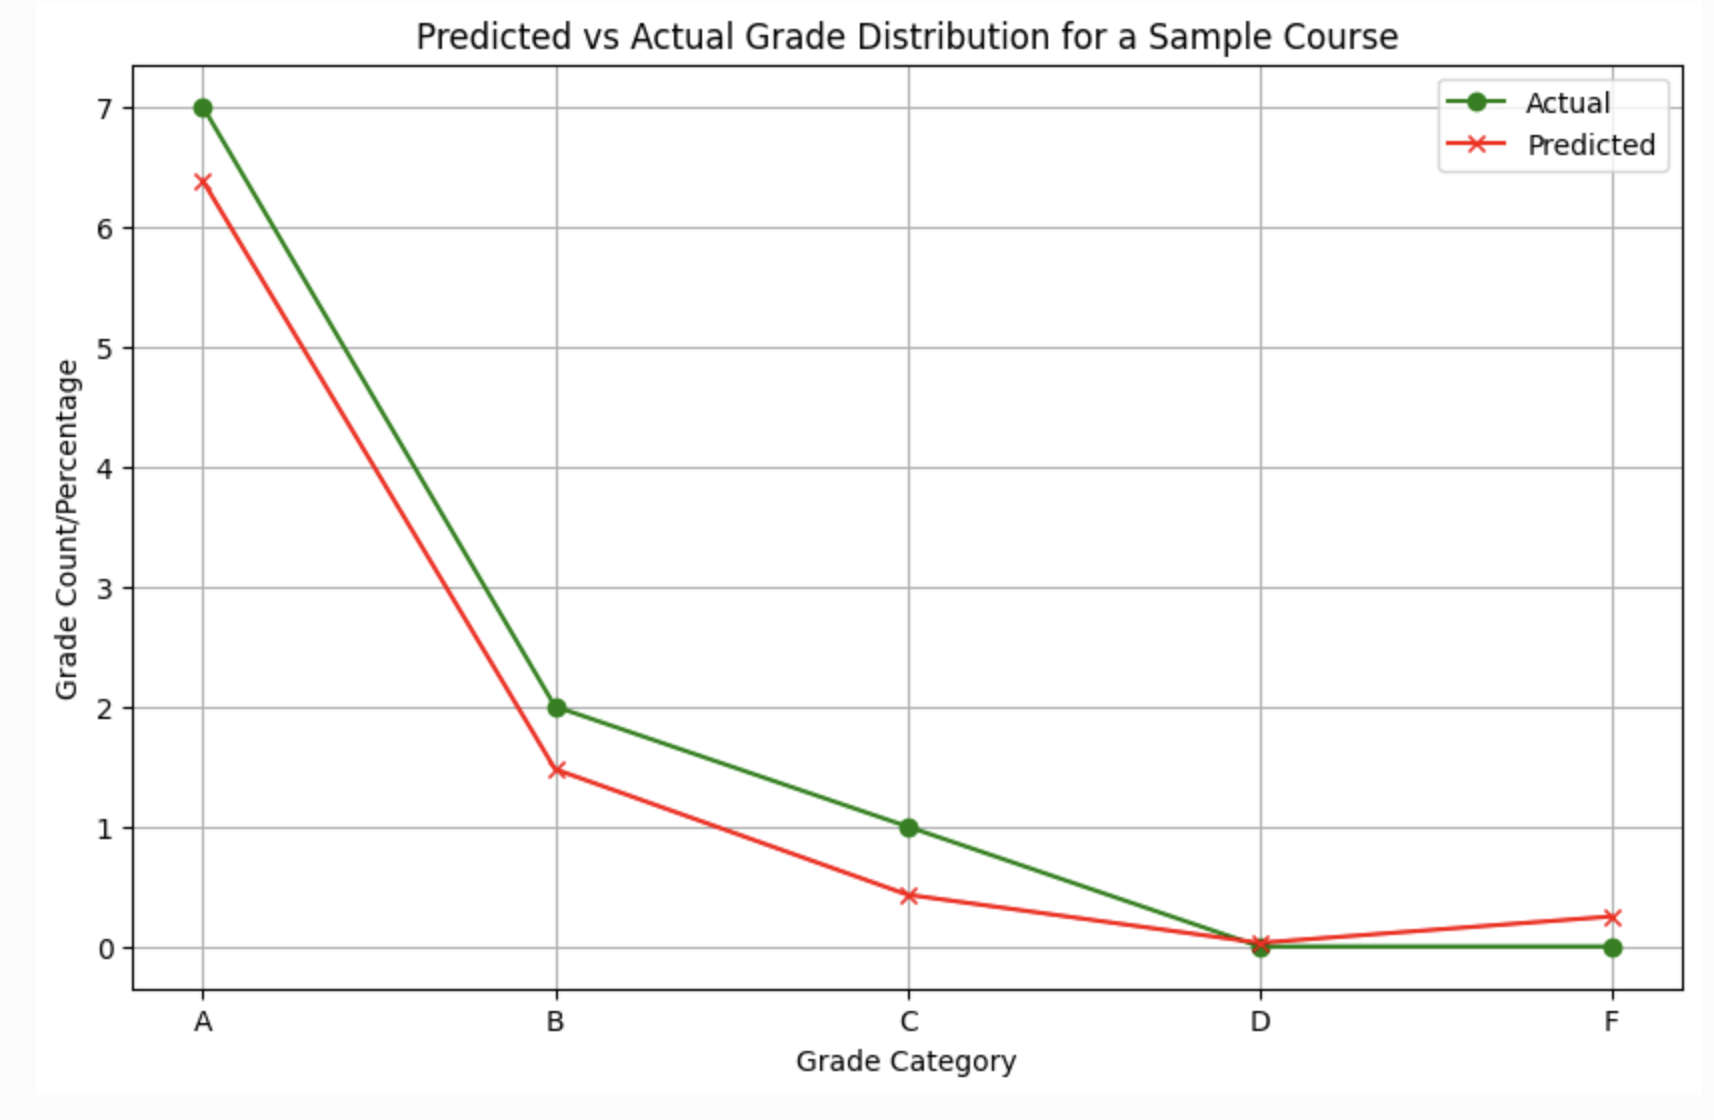

- *Predicted vs. Actual Grades*:
   A further visualization comparing the predicted vs. actual grade distributions for a sample course can be used to understand the model's prediction accuracy for specific cases. This visual comparison can reveal where the model tends to overestimate or underestimate certain grades.
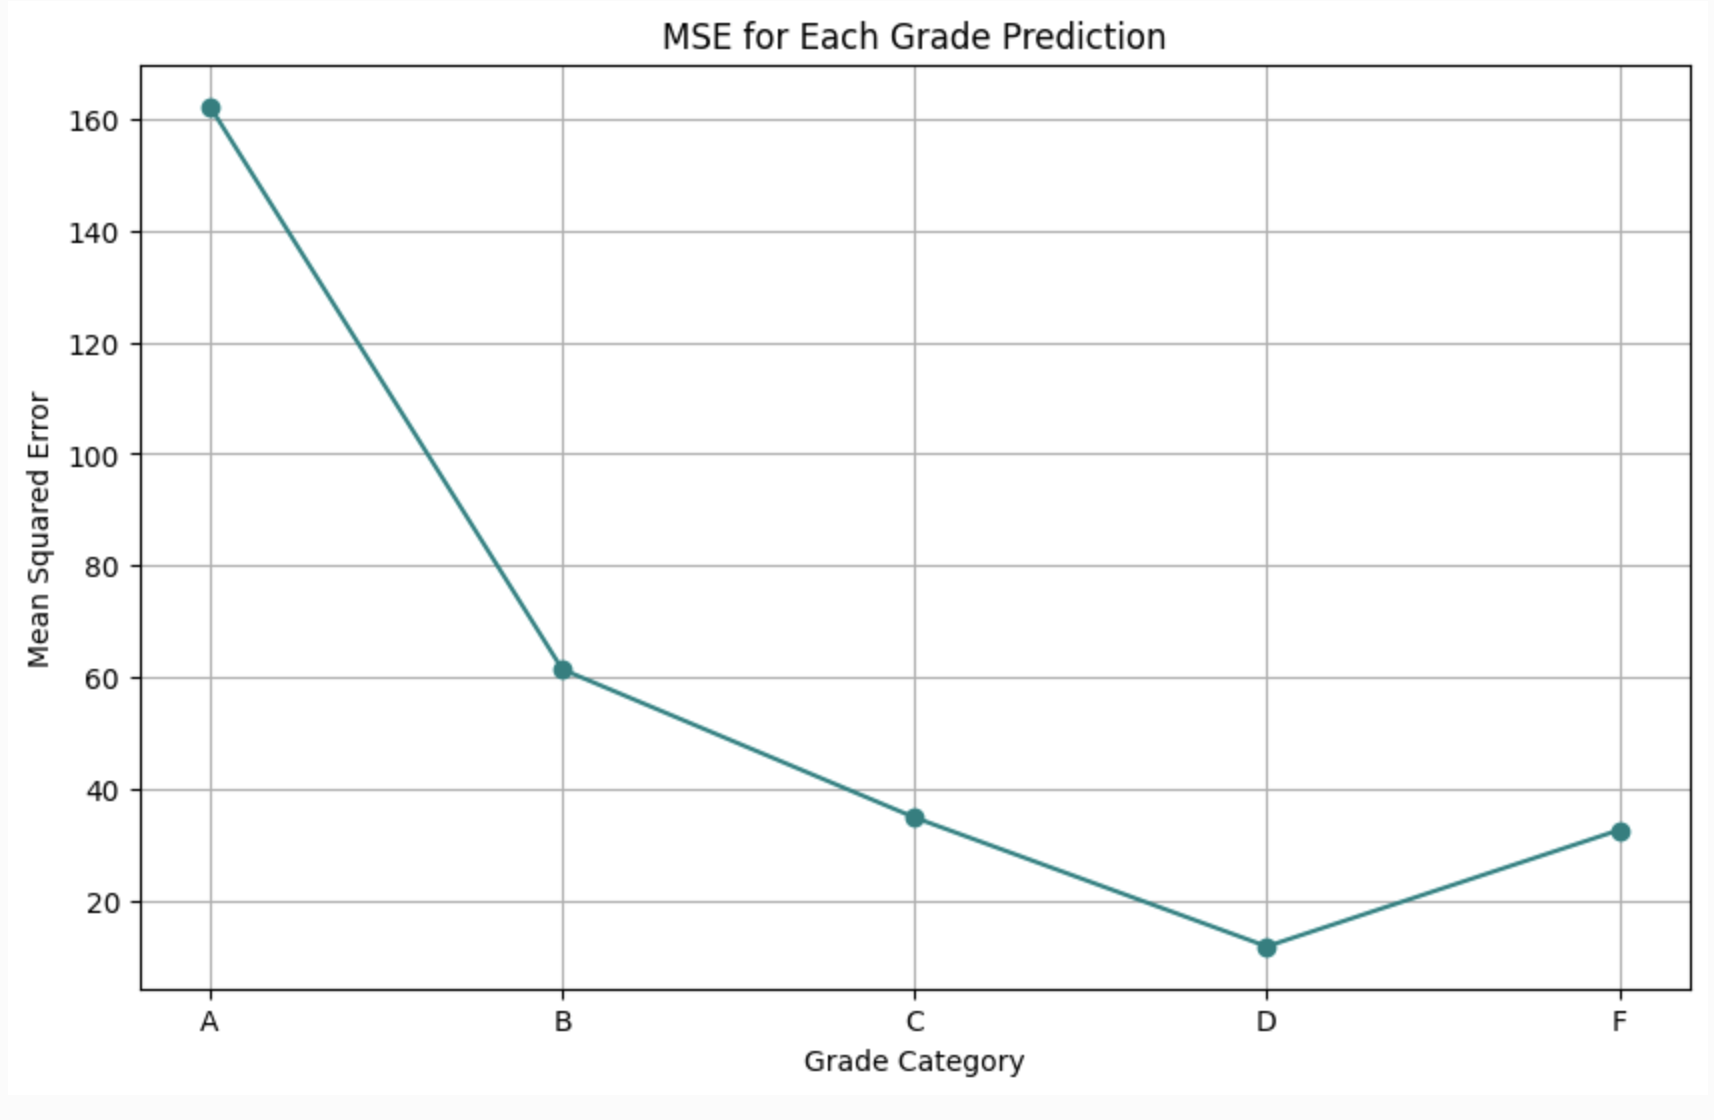


### *Conclusion:*
- The *Random Forest Regressor* model is effective in predicting grade distributions, with *Class Size* identified as the most influential feature. The model performs better than a simple baseline approach (predicting the mean for each grade category), especially for grades with larger distributions like *Grade D* and *Grade F*.
- The MSE values indicate that predictions for *Grade A* are more challenging due to the lower number of students achieving an A, while *Class Size* remains the primary factor influencing grade outcomes.
- This analysis demonstrates the potential of machine learning models in predicting grade distributions based on various course and instructor characteristics, which can help in understanding and potentially improving academic performance forecasting.

This analysis can be expanded further by exploring additional features, tuning the model, or experimenting with other machine learning algorithms for potentially better predictions.



Feature Statistics:
             Rating  Num Reviews   Class Size  Semester Encoded
count  1136.000000  1136.000000  1136.000000       1136.000000
mean      3.366699    45.959507    77.633803          0.639965
std       0.812191    43.064751    72.929497          0.615330
min       1.000000     0.000000    10.000000          0.000000
25%       2.700000    11.000000    28.000000          0.000000
50%       3.366699    25.000000    52.000000          1.000000
75%       4.000000    82.000000    97.250000          1.000000
max       5.000000   144.000000   440.000000          2.000000

Mean Squared Error for each grade category: [162.2491433   61.42415575  34.88534573  11.78439886  32.63805025]


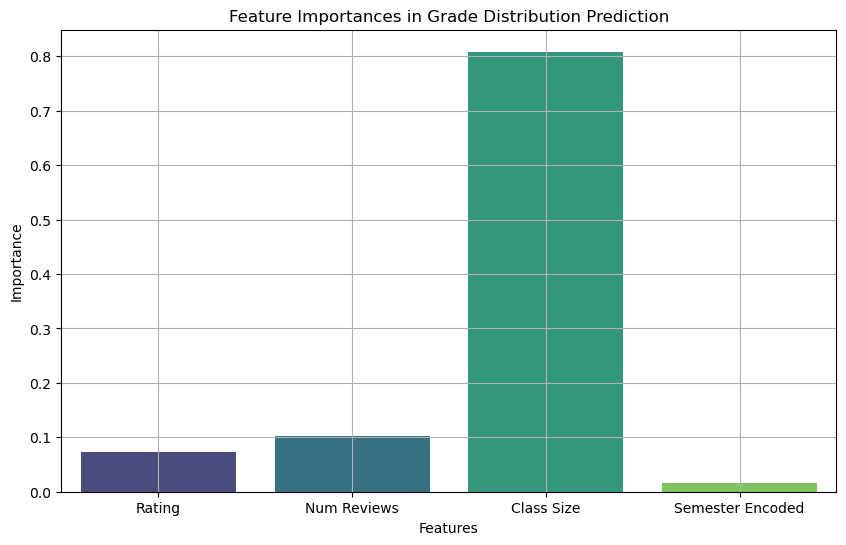

In [25]:
# Load the datasets
grade_data = cs_grades
rmp_data = cs_rmp
course_desc = cs_descrip

# Ensure proper formatting of CRS SUBJ CD and CRS NBR to create Course_Code
grade_data['Course_Code'] = grade_data['CRS SUBJ CD'].str.strip() + " " + grade_data['CRS NBR'].astype(str).str.zfill(3).str.strip()

# Function to clean and extract first and last names from "Last, First" format
def clean_instructor_name(name):
    parts = name.split(',')
    if len(parts) == 2:
        first_last = parts[1].strip() + ' ' + parts[0].strip()  # "First Last"
        return first_last
    return name.strip()

# Clean up instructor names in both grade data and RMP data
grade_data['Instructor Cleaned'] = grade_data['Primary Instructor'].apply(clean_instructor_name)
rmp_data['Instructor Cleaned'] = rmp_data['Instructor'].apply(clean_instructor_name)

# Merge grade data with RMP data on Cleaned Instructor Name
merged_data = pd.merge(grade_data, rmp_data[['Instructor Cleaned', 'Rating', 'Num Reviews']], 
                       left_on='Instructor Cleaned', right_on='Instructor Cleaned', how='left')

# Clean up Course column in course_desc to match Course_Code format
course_desc['Course'] = course_desc['Course'].str.strip()

# Merge with course descriptions
merged_data = pd.merge(
    merged_data,
    course_desc[['Course', 'Course Title']],  # Use relevant columns from course_desc
    left_on='Course_Code',
    right_on='Course',
    how='left'
)

# Fill missing RMP ratings and reviews with appropriate values
merged_data['Rating'] = merged_data['Rating'].fillna(merged_data['Rating'].mean())
merged_data['Num Reviews'] = merged_data['Num Reviews'].fillna(0)

# Feature Engineering
merged_data['Class Size'] = merged_data['Grade Regs']  # Total registered students in the class
merged_data['Semester Encoded'] = pd.Categorical(merged_data['SEMESTER']).codes  # Encode semester as numeric

# Define features and target variables
features = merged_data[['Rating', 'Num Reviews', 'Class Size', 'Semester Encoded']]
target = merged_data[['A', 'B', 'C', 'D', 'F']]

# Feature Statistics (Summary)
print("\nFeature Statistics:\n", features.describe())

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize and train the model
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
model.fit(X_train, y_train)

# Predict on the test set
from sklearn.metrics import mean_squared_error
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')

# Display the MSE results
print("\nMean Squared Error for each grade category:", mse)

# Visualization: MSE for each grade category
'''import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(target.columns, mse, marker='o', color='teal')
plt.title("MSE for Each Grade Prediction")
plt.xlabel("Grade Category")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.show()'''

# Visualization: Predicted vs. Actual Grades for a sample of the test set
'''sample_index = 0  # Modify this index to check other test samples
plt.figure(figsize=(10, 6))
plt.plot(target.columns, y_test.iloc[sample_index], label="Actual", marker='o', color='green')
plt.plot(target.columns, y_pred[sample_index], label="Predicted", marker='x', color='red')
plt.title("Predicted vs Actual Grade Distribution for a Sample Course")
plt.xlabel("Grade Category")
plt.ylabel("Grade Count/Percentage")
plt.legend()
plt.grid()
plt.show()'''

# Feature Importance Visualization
import seaborn as sns
feature_importances = model.estimators_[0].feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=features.columns, y=feature_importances, palette="viridis")
plt.title("Feature Importances in Grade Distribution Prediction")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.grid()
plt.show()
